In [1]:
from utils import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import pickle
#import sys
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

from pymongo import MongoClient

/home/eleanor/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/eleanor/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)
/home/eleanor/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/eleanor/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [2]:
client = MongoClient()
db = client.cmv
posts_collection = db.posts
tl_comments_collection = db.tl_comments
deltad_replies_collection = db.deltad_replies

In [3]:
random_state = 42

In [4]:
# establish the set of texts to use (ie posts vs comments)
doctype = 'post'

In [5]:
deltad_docs, undeltad_docs = get_docs(posts_collection, tl_comments_collection,
                                      key_phrase_exists=True)

processing post 0
processing post 50
processing post 100
processing post 150
processing post 200
processing post 250
processing post 300
processing post 350
processing post 400
processing post 450
processing post 500
processing post 550
processing post 600
processing post 650
processing post 700
processing post 750
processing post 800
processing post 850
processing post 900
processing post 950
processing post 1000
processing post 1050
processing post 1100
processing post 1150
processing post 1200
processing post 1250
processing post 1300
processing post 1350
processing post 1400
processing post 1450
processing post 1500
processing post 1550
processing post 1600
processing post 1650
processing post 1700
processing post 1750
processing post 1800
processing post 1850
processing post 1900
processing post 1950
processing post 2000
processing post 2050
processing post 2100
processing post 2150
processing post 2200
processing post 2250
processing post 2300
processing post 2350
processing post

In [6]:
train_docs, test_docs, val_docs = doc_split(deltad_docs, undeltad_docs, rand_state=random_state)
deltad_docs=[]
undeltad_docs=[]

In [7]:
len(train_docs)

20057

In [8]:
len(test_docs)

6686

In [9]:
len(val_docs)

6685

In [11]:
train_comment_ids, train_comment_texts, train_labels, train_post_ids, train_post_texts = get_fields(train_docs)
test_comment_ids, test_comment_texts, test_labels, test_post_ids, test_post_texts = get_fields(test_docs)
val_comment_ids, val_comment_texts, val_labels, val_posts_ids, val_post_texts = get_fields(val_docs)

In [5]:
trainfile = 'train.pickle'
testfile = 'test.pickle'
valfile = 'val.pickle'

In [12]:
with open(trainfile, 'wb') as f:
    pickle.dump((train_comment_ids, train_comment_texts, train_labels, train_post_ids, train_post_texts), f)
with open(testfile, 'wb') as f:
    pickle.dump((test_comment_ids, test_comment_texts, test_labels, test_post_ids, test_post_texts), f)
with open(valfile, 'wb') as f:
    pickle.dump((val_comment_ids, val_comment_texts, val_labels, val_posts_ids, val_post_texts), f)

## Unsupervised Topic Extraction with PyTextRank

In [13]:
# strip unnecessary punctuation from selects 'id' and 'text' fields from docs
train_dicts = get_ptr_dicts(train_docs)

In [ ]:
train_docs = None
test_docs = None
val_docs = None

In [20]:
from utils import insert_key_phrases_into_db

In [21]:
insert_key_phrases_into_db(train_dicts[0:2], doctype='comment', collection=tl_comments_collection)

processing 0 of 2 documents


/home/eleanor/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/eleanor/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


## Vectorize documents using Key Phrases from PyTextRank

In [18]:
post_key_phrases = kparray=get_all_key_phrases(posts_collection, 'post', train_post_ids)
comment_key_phrases = kparray=get_all_key_phrases(tl_comments_collection, 'comment', train_comment_ids)
all_key_phrases = np.union1d(post_key_phrases, comment_key_phrases)
post_key_phrases = []
comment_key_phrases = []
len(all_key_phrases)

18852 unique key phrases from 2120 documents
67194 unique key phrases from 20057 documents


In [19]:
with open('all_key_phrases.pickle', 'wb') as f:
    pickle.dump(all_key_phrases, f)

In [21]:
train_labels = 0
test_comment_ids, test_comment_texts, test_labels, test_post_ids, test_post_texts = (None, None, None, None, None)
val_comment_ids, val_comment_texts, val_labels, val_posts_ids, val_post_texts = (None, None, None, None, None)

In [10]:
def clean_text(texts):
    '''
    Takes in list of text strings to tokenize, returns cleaned texts,
    with all punctuation and digits stripped and all characters converted to lowercase
    '''
    cleaned_texts = []
    for text in texts:
        #strip punctuation and digits from whole text
        to_replace = [punc for punc in string.punctuation+string.digits if punc!="'"]
        translate_dict = {key: ' ' for key in to_replace}
        translate_dict["'"] = ''
        replacement_table = str.maketrans(translate_dict)
        stripped_text = text.translate(replacement_table)
        #lower case text
        lowered_text = stripped_text.lower()
        cleaned_texts.append(lowered_text)
    return cleaned_texts

In [12]:
# train
train_comment_texts = clean_text(train_comment_texts)

In [6]:
with open('all_key_phrases.pickle', 'rb') as f:
    all_key_phrases = pickle.load(f)

In [7]:
my_vectorizer = CountVectorizer(vocabulary=all_key_phrases, ngram_range=(1,3))

In [13]:
train_comment_texts = my_vectorizer.fit_transform(train_comment_texts)

In [14]:
col_sums = train_comment_texts.sum(axis=0).A
col_sums=col_sums.tolist()[0]
len(col_sums)

78167

In [15]:
sorted_labeled_cols = sorted(list(zip(all_key_phrases,col_sums)), key= lambda x: x[1], reverse=True)
col_sums = None

In [16]:
filtered_labeled_cols = list(filter(lambda x: x[0] not in set(stopwords.words('english')), sorted_labeled_cols))
sorted_labeled_cols = None

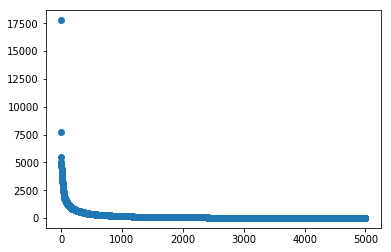

In [219]:

%matplotlib inline
plt.scatter(range(len(filtered_labeled_cols[0:5000])), [x[1] for x in filtered_labeled_cols[0:5000]])

In [17]:
#remove 'people' and 'one', keep remaining top 5000
phrases_to_keep = [x[0] for x in filtered_labeled_cols[0:3002]]
phrases_to_keep.remove(filtered_labeled_cols[0][0])
phrases_to_keep.remove(filtered_labeled_cols[1][0])

In [32]:
filtered_labeled_cols = 0

In [8]:
# train
with open(trainfile, 'rb') as f:
    (train_comment_ids, train_comment_texts, train_labels, train_post_ids, train_post_texts) = pickle.load(f)

In [18]:
train_comment_texts = pd.SparseDataFrame(train_comment_texts, columns=all_key_phrases)

In [19]:
# train
train_comment_texts.drop([x for x in train_comment_texts.columns if x not in phrases_to_keep], axis=1, inplace=True)

In [22]:
train_comment_df_filename='train_comment_df.pickle'
with open(train_comment_df_filename, 'wb') as f:
    pickle.dump(train_comment_texts, f)
    
train_comment_ids, train_comment_texts, train_labels = (None, None, None)

In [23]:
train_post_texts = clean_text(train_post_texts)

In [24]:
train_post_texts = my_vectorizer.transform(train_post_texts)

In [25]:
train_post_texts = pd.SparseDataFrame(train_post_texts, columns=all_key_phrases)

In [26]:
train_post_texts.drop([x for x in train_post_texts.columns if x not in phrases_to_keep], axis=1, inplace=True)

In [262]:
train_post_df_filename='train_post_df.pickle'
with open(train_post_df_filename), wb) as f:
    pickle.dump(train_post_texts, f)
    
train_post_ids, train_post_texts = (None,None)

In [31]:
# test
with open(testfile, 'rb') as f:
    (test_comment_ids, test_comment_texts, test_labels, test_post_ids, test_post_texts) = pickle.load(f)

In [32]:
test_comment_texts = clean_text(test_comment_texts)

In [33]:
test_comment_texts = my_vectorizer.transform(test_comment_texts)

In [34]:
test_comment_texts = pd.SparseDataFrame(test_comment_texts, columns=all_key_phrases)
test_comment_texts.drop([x for x in test_comment_texts.columns if x not in phrases_to_keep], axis=1, inplace=True)

In [37]:
test_comment_df_filename='test_comment_df.pickle'
with open(test_comment_df_filename, 'wb') as f:
    pickle.dump(test_comment_texts, f)

test_comment_ids, test_comment_texts, test_labels = (None, None, None)

In [38]:
test_post_texts = clean_text(test_post_texts)

In [39]:
test_post_texts = my_vectorizer.transform(test_post_texts)

In [40]:
test_post_texts = pd.SparseDataFrame(test_post_texts, columns=all_key_phrases)
test_post_texts.drop([x for x in test_post_texts.columns if x not in phrases_to_keep], axis=1, inplace=True)

In [41]:
test_post_df_filename='test_post_df.pickle'
with open(test_post_df_filename, 'wb') as f:
    pickle.dump(test_post_texts, f)
    
test_post_ids, test_post_texts = (None, None)

In [42]:
# validation set
with open(valfile, 'rb') as f:
    (val_comment_ids, val_comment_texts, val_labels, val_posts_ids, val_post_texts) = pickle.load(f)

In [43]:
val_comment_texts = clean_text(val_comment_texts)

In [44]:
val_comment_texts = my_vectorizer.transform(val_comment_texts)

In [45]:
val_comment_texts = pd.SparseDataFrame(val_comment_texts, columns=all_key_phrases)
val_comment_texts.drop([x for x in val_comment_texts.columns if x not in phrases_to_keep], axis=1, inplace=True)

In [46]:
val_comment_df_filename='val_comment_df.pickle'
with open(val_comment_df_filename, 'wb') as f:
    pickle.dump(val_comment_texts, f)
    
val_comment_ids, val_comment_texts, val_labels, = (None, None, None)

In [47]:
val_post_texts = clean_text(val_post_texts)

In [48]:
val_post_texts = my_vectorizer.transform(val_post_texts)

In [49]:
val_post_texts = pd.SparseDataFrame(val_post_texts, columns=all_key_phrases)
val_post_texts.drop([x for x in val_post_texts.columns if x not in phrases_to_keep], axis=1, inplace=True)

In [51]:
val_post_df_filename='val_post_df.pickle'
with open(val_post_df_filename, 'wb') as f:
    pickle.dump(val_post_texts, f)
    
val_posts_ids, val_post_texts = (None, None)

In [ ]:
# transform test, val comment sets and all post sets
# cut down all matrices based on filter
# concatenate comment/post arrays for train, test, val
# pickle arrays and/or insert into tl_comments_collection or new collection

In [ ]:

#vectorized_test_comments = my_vectorizer.transform(cleaned_test_comments)